# Introduction

This notebook implements a solution to the classification problem involving sarcastic and non-sarcastic news headlines. Provided data consists of 26 709 string-like headlines of variable lengths, each marked with a binary label (0 for genuine, 1 for sarcastic).

Solving the problem began with a research stage, conducted in order to recognize the current state of knowledge on the subject. Preliminary reading confirmed that the elements of deep learning had to be incorporated as traditional machine learning was investigated to perform rather poorly in such complex NLP tasks. If computation time and simplicity of the model were important factors in the assignment, these methods could be verified nonetheless. Support vector machines could be a good starting point, as they are mentioned in a few of the early publications on the subject of sentence classification.

For the described solution, the method chosen after the research was convolutional neural network (CNN). During the completion of the project, three scientific papers were mainly consulted as a description of a state-of-the-art method for the problem of that type. These papers were:

Mehendiratta P., Devpriya S., Identification of Sarcasm in Textual Data: A Comparative Study (2019), available [here](https://www.researchgate.net/publication/338223940_Identification_of_Sarcasm_in_Textual_Data_A_Comparative_Study_Identification_of_Sarcasm_in_Textual_Data_A_Comparative_Study)\
Zhang Y., Wallace B. C., A Sensitivity Analysis of (and Practitioner's Guide to) Convolutional Neural Networks for Sentence Classification (2016), available [here](https://arxiv.org/abs/1510.03820)\
Kim Y., Convolutional Neural Networks for Sentence Classification (2014), available [here](https://www.aclweb.org/anthology/D14-1181/)

Core functionalities of the project were implemented using Keras. The code was written using [this](https://gist.github.com/entron/b9bc61a74e7cadeb1fec), [this](https://www.kaggle.com/danielsafai/cnn-implementation-of-yoon-kim-s-model) and [this](https://www.kaggle.com/hamishdickson/cnn-for-sentence-classification-by-yoon-kim/data) online repositories as references.

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
current_dir = os.path.dirname(os.path.abspath('__file__'))
path_to_file = os.path.join(current_dir, 'Graduate - HEADLINES dataset (2019-06).json')
input_data = pd.read_json(path_to_file, orient = 'records', lines = True)
input_data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
headline        26709 non-null object
is_sarcastic    26709 non-null int64
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [5]:
input_data['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

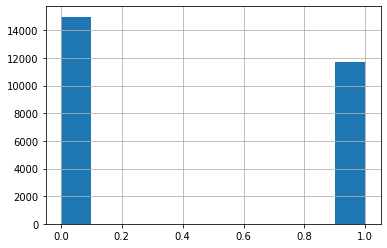

In [45]:
input_data['is_sarcastic'].hist(figsize = (6, 4))

Firstly, data in .json format was read into pandas DataFrame. The most important features and statistics of the data set were examined. It turned out to be complete, so no imputation had to be performed. More importantly, it was confirmed that the ratio of sarcastic examples to non-sarcastic ones was not excessively low, which was an important observation concerning the choice of a model and hyperparameter tuning.

The next important step was vectorization of textual data. This NLP operation allows to represent a string as a vector of numbers, calculated in such a way to ensure that words close to eah other in meaning are also located close in the vector space. Two word embedding methods are popular among researchers in the field: Word2Vec and GloVe. The latter was chosen to be used in a processing stage of the project. Unlike Word2Vec, it does not utilize the local context window of the word, but is constructed using global word co-occurance matrix. As a result, it should be more general and help achieve better model performance. 

Pre-trained word vectors are available for download via GloVe [website](https://nlp.stanford.edu/projects/glove/). The set used in this project is a collection trained on Wikipedia and Gigaword entries and has a vocabulary size of 400 000. The dimensionality of each vector is 300, which is consistent with Kim's work. Function read_embeddings() takes a path to a file containing GloVe matrix and returns a dictionary, mapping each word to its vector (NumPy array).

In [7]:
def read_embeddings(path_to_embeds):
    
    embeddings_dict = {}

    with open(path_to_embeds, 'r') as glove_vectors:
        for vector in glove_vectors:
            values = vector.split()
            word = values[0]
            vect_in_dict = np.asarray(values[1:], dtype = np.float32)
            embeddings_dict[word] = vect_in_dict
    
    return embeddings_dict

In [8]:
embeddings_path = '/home/radoslawregula/Documents/GloVe/glove.6B.300d.txt'
embeddings = read_embeddings(embeddings_path)

print('Num of words: ', len(embeddings))

Num of words:  400000


In [9]:
input_data.loc[:,'len'] = input_data['headline'].apply(lambda x: len(str(x).split(' ')))
print('Max length of a headline: ', input_data['len'].max())

Max length of a headline:  39


At that point, the input data had to be tokenized. Tokenization allows to represent a text as a sequence of integers, and by default group the same words tegether. This step prepares headline data to be transformed into *c x d* matrix for each entry, where c is a length of a headline and d is a dimensionality of word embedding. After tokenization, sequences of integers were zero-padded to ensure equal size of each matrix. 

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 40000
padded_max_len = 40

tokenizer = Tokenizer(num_words = max_features, oov_token = 'unknown')
tokenizer.fit_on_texts(input_data['headline'].values)

X = tokenizer.texts_to_sequences(input_data['headline'].values)
X = pad_sequences(X, padded_max_len, padding = 'post')

y = input_data['is_sarcastic'].values

Data was split into training and testing sets with 80/20 proportion.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

As a last step of processing before constructing the model, embedding matrix was prepared. Embedding matrix is a structure connecting tokenized input sentences and a model GloVe dictionary. The function below looks for words from the headlines in *embeddings* dict, and adds their vectors to the final matrix. This operation returns a final link between textual data that was provided in the file and a neural network model operating on numerical inputs.

An important feature is that if the function fails to connect a word to its representation in a Glove dictionary, it constructs a random vector. It prevents unrecognized entries from being grouped together into one vector (e.g. filled with zeros).

A shape of 29658 x 300 suggests that the input data consisted of about 29658 separate words.

In [12]:
embedding_dimensions = 300
no_filters = 100

num_words = min(max_features, len(tokenizer.word_index)) + 2

embedding_matrix = np.zeros((num_words, embedding_dimensions))

for word, index in tokenizer.word_index.items():
    if index > max_features:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_matrix[index] = np.random.randn(embedding_dimensions)

print(embedding_matrix.shape)

(29658, 300)


At this point the data is prepared to be fed to a neural network. The model is initialized and built based on designs described in aforementioned scientific works. Schematic illustration of the algorithm is presented below (Source: Zhang's and Wallace's work):\
![cnn-fig](https://i.pinimg.com/564x/ea/f7/39/eaf739a2bf6abc104c3238db111207b5.jpg)\
Embedding layer turns indexes of integer into dense vectors. The white matrix on the image above is constructed from this vectors using Reshape class. The embedding layer is trainable - it is fine-tuned based on data and performance of a model. It is an example of 'non-static' version of CNN, a version which was proven to achieve better accuracy.

Next layer is a convolution layer. It performs 2D convolution of an input matrix with ((3, 4, 5) x 300) filters. This layer uses ReLU activation function and is regularized with l<sub>2</sub> constraint of 3. This filtration operation produces a *feature map*. After that, pooling layer performs max pooling over each feature map. This step captures features the most important for modelling. Vectors obtained in the way described are then concatenated (to integrate features extracted by individual filters), flattened and used for classification by the means of a sigmoid function. The final prediction is 1 if the value of the function is above 0.5, and 0 otherwise. Reguralization of the model with dropout is also implemented, with a rate of 0.5, also used by Kim. 

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.initializers import Constant 
from tensorflow.keras import regularizers

filter_sizes = (3, 4, 5)
dropout_rate = 0.5

inputs = Input(shape = (padded_max_len,), dtype = np.int32)

embedding_layer = layers.Embedding(num_words, 
                                   embedding_dimensions, 
                                   embeddings_initializer = Constant(embedding_matrix),
                                   input_length = padded_max_len, 
                                   trainable = True)(inputs)
reshape = layers.Reshape((padded_max_len, embedding_dimensions, 1))(embedding_layer)

convolutions = []

for size in filter_sizes:
    convolutions.append(layers.Conv2D(no_filters, 
                                      kernel_size = (size, embedding_dimensions),
                                      padding = 'valid',
                                      kernel_initializer = 'normal',
                                      activation = 'relu', 
                                      kernel_regularizer = regularizers.l2(3))(reshape))
    
maxpools = []

for size in filter_sizes:
    maxpools.append(layers.MaxPool2D(pool_size = (padded_max_len - size + 1, 1), 
                                     strides = (1, 1), 
                                     padding = 'valid')(convolutions[size - 3]))

concatenated_tensor = layers.Concatenate(axis = 1)(maxpools)
flatten = layers.Flatten()(concatenated_tensor)

dropout = layers.Dropout(dropout_rate)(flatten)
output = layers.Dense(units = 1, activation = 'sigmoid')(dropout)


In [33]:
model = Model(inputs = inputs, outputs = output)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 300)      8897400     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 40, 300, 1)   0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 38, 1, 100)   90100       reshape_2[0][0]                  
____________________________________________________________________________________________

The model is compiled and fitted to the training set. 

In [15]:
batch_size = 50
history = model.fit(X_train, y_train, epochs = 30, batch_size = batch_size, verbose = 1, validation_split = 0.2)

Train on 17093 samples, validate on 4274 samples
Epoch 1/30
17093/17093 [==============================] - 108s 6ms/sample - loss: 242.4705 - accuracy: 0.5590 - val_loss: 0.7638 - val_accuracy: 0.5538
Epoch 2/30
17093/17093 [==============================] - 110s 6ms/sample - loss: 0.7178 - accuracy: 0.5629 - val_loss: 0.7164 - val_accuracy: 0.5538
Epoch 3/30
17093/17093 [==============================] - 113s 7ms/sample - loss: 0.7180 - accuracy: 0.5629 - val_loss: 0.7180 - val_accuracy: 0.5538
Epoch 4/30
17093/17093 [==============================] - 114s 7ms/sample - loss: 0.7174 - accuracy: 0.5991 - val_loss: 0.7314 - val_accuracy: 0.7050
Epoch 5/30
17093/17093 [==============================] - 112s 7ms/sample - loss: 0.7217 - accuracy: 0.7323 - val_loss: 0.7286 - val_accuracy: 0.7693
Epoch 6/30
17093/17093 [==============================] - 117s 7ms/sample - loss: 0.7417 - accuracy: 0.7709 - val_loss: 0.7918 - val_accuracy: 0.7773
Epoch 7/30
17093/17093 [=========================

Accuracy metric of the trained model is impressive, peaking at almost 97%, but it is not difficult to notice that the cross-validation results suggest that the model is overfitted. This conclusion is easily deduced from the visualization - while training set's accuracy increases gradually, cross-validation's accuracy stays at roughly the same value.

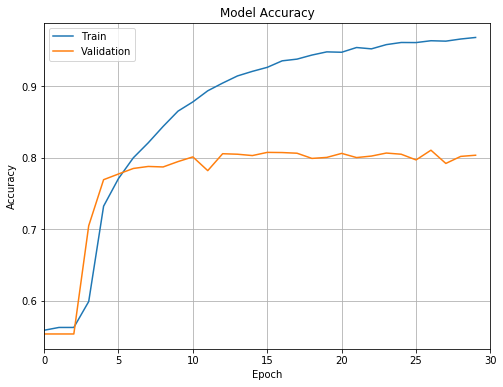

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, 30])
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

To prevent overfitting, the model was regularized with early stopping. The hyperparameters stayed the same, but the learning process was halted if the accuracy of validation set's predictions stayed at roughly the same level for 3 consecutive epochs. 

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

model_stopped = Model(inputs = inputs, outputs = output)
model_stopped.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

batch_size = 50

early_stop = EarlyStopping(monitor = 'val_accuracy',
                           min_delta = 0.015,
                           patience = 3)

history_stopped = model_stopped.fit(X_train, 
                                    y_train, 
                                    epochs = 30,
                                    callbacks = [early_stop],
                                    batch_size = batch_size, 
                                    verbose = 1, 
                                    validation_split = 0.2)

Train on 17093 samples, validate on 4274 samples
Epoch 1/30
17093/17093 [==============================] - 110s 6ms/sample - loss: 241.9731 - accuracy: 0.5543 - val_loss: 0.7589 - val_accuracy: 0.5538
Epoch 2/30
17093/17093 [==============================] - 113s 7ms/sample - loss: 0.7165 - accuracy: 0.5629 - val_loss: 0.7193 - val_accuracy: 0.5538
Epoch 3/30
17093/17093 [==============================] - 113s 7ms/sample - loss: 0.7174 - accuracy: 0.5629 - val_loss: 0.7201 - val_accuracy: 0.5538
Epoch 4/30
17093/17093 [==============================] - 108s 6ms/sample - loss: 0.7147 - accuracy: 0.6038 - val_loss: 0.7219 - val_accuracy: 0.5774
Epoch 5/30
17093/17093 [==============================] - 105s 6ms/sample - loss: 0.7209 - accuracy: 0.7277 - val_loss: 0.7340 - val_accuracy: 0.7665
Epoch 6/30
17093/17093 [==============================] - 111s 6ms/sample - loss: 0.7387 - accuracy: 0.7664 - val_loss: 0.7604 - val_accuracy: 0.7620
Epoch 7/30
17093/17093 [=========================

Early stopping worked well - the overall performance of the model is worse, but the generalization of incoming data is more suitable. 

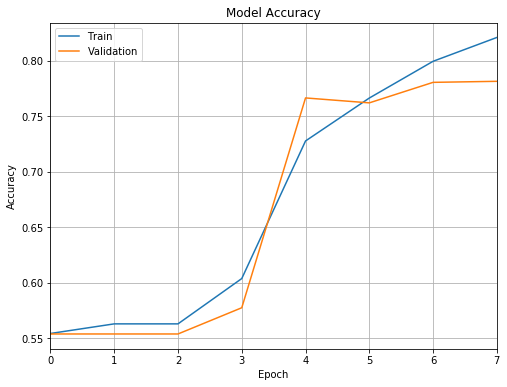

In [37]:
plt.figure(figsize = (8, 6))
plt.plot(model_stopped.history.history['accuracy'])
plt.plot(model_stopped.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, 7])
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

The models are saved for potential future use.

In [40]:
from tensorflow.keras.models import load_model
from tensorflow.python.util import deprecation

deprecation._PRINT_DEPRECATION_WARNINGS = False
model.save('overfitted_model.tf', save_format = 'tf')
model_stopped.save('final_model.tf', save_format = 'tf')

INFO:tensorflow:Assets written to: overfitted_model.tf/assets
INFO:tensorflow:Assets written to: final_model.tf/assets


The assessment of the model is performed on the test set. Metrics chosen for this task are: accuracy, confusion matrix and area under ROC curve.

In [41]:
y_predictions_test = model_stopped.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

acc_score = accuracy_score(y_test, list(map(lambda u: u > 0.5, y_predictions_test)))
confusion_mx = confusion_matrix(y_test, list(map(lambda u: u > 0.5, y_predictions_test)))
auc_score = roc_auc_score(y_test, list(map(lambda u: u > 0.5, y_predictions_test)))

print('Accuracy score for the test set: ', acc_score)
print('Confusion matrix for the test set: \n', confusion_mx)
print('ROC AUC for the test set: ', auc_score)

Accuracy score for the test set:  0.7929614376637963
Confusion matrix for the test set: 
 [[2395  601]
 [ 505 1841]]
ROC AUC for the test set:  0.7920695909408055


# Summary of the project

Convolutional neural network implemented for the classification of sarcastic news headlines performed well: achieving **accuracy of 82% for the training set and 79% for the test set**. Since the number of 0 classes and the number of 1 classes in the input set is comparable, this metric works well and is a precise representation of performance. For the test set, confusion matrix was calculated to further understand the logic of algorithm's classification. The number of false positives turned out to be greater than the number of false negatives. This seems to be a less 'dangerous' option. In general, this kind of task requires high recall in order to rather classify genuine sentences as sarcastic than sarcastic sentences as genuine (assuming our goal is to warn the end user about the possibility of ironic content).

The area under receiver operating characteristic was also calculated and had a value of **over 0.79**. 

Of course, the model implemented in this notebook could be improved. The hyperparameters' values were based on exisiting research. Instead, there is a possibility of performing a grid search to create a custom set of parameters, fitted specially to the task. The CNN method itself could turn out to not be the most effective model for this task (it is rather unlikely, though). That can be verified by first implementing a few different neural network architectures and conventional ML algorithms and assess the results accordingly. Overfitting can also be decreased by stronger regularization, e.g. increasing the dropout rate. If that method turns out to help validation accuracy grow together with training set's accuracy further, that one should be used in the project. More possible ways to ensure better results are described exhaustively in Zhang's and Wallace's paper.